In [27]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Sequential, Model
from keras.models import model_from_json
from tensorflow import keras
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [28]:
df1 = pd.read_pickle("../Data/returns.pkl").iloc[1:]

drop_columns = []
for col in df1.columns:
    if df1[col].isnull().all() == True:
        drop_columns.append(col)
        
df1.drop(columns=drop_columns, inplace=True)

In [29]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = df1.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [30]:
df1 = get_investable(pd.to_datetime('2018-05-11'),500)

In [31]:
tts = train_test_split(df1, test_size=0.2, shuffle=False)
train = tts[0]
test = tts[1]

In [32]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train)
test_set_scaled = sc.fit_transform(test)

In [44]:
# calculated log returns (i.e. the log of the difference between the price x+1 and price x)
# windows of train.shape[1] consecutive returns will be produced. 
# normalized with a MinMaxScaler to the range [0,1].

epochs = 250
batch_size = 1024

class simple_autoencoder():
    
    def __init__(self):
        pass
    
    def reduced_dim(self):
        encoding_dim = 20
        window_length = training_set_scaled.shape[1]
        input_window = Input(shape=(window_length,))
        # encoded representation of the input
        encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
        # model mapping an input to its encoded representation
        encoder = Model(input_window, encoded)
        return pd.DataFrame(encoder.predict(test_set_scaled)).head()

#Alternative: optimizer = "Adam", score = 'acc', loss = "mean_squared_error", dim = 20
    def model(self,optimizer = "Adam", score = 'mae', loss = "mse", dim = 25):
        encoding_dim = dim
        window_length = training_set_scaled.shape[1]
        # input placeholder
        input_window = Input(shape=(window_length,))
        # encoded representation of the input
        encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
        # lossy reconstruction of the input
        decoded = Dense(window_length, activation='linear')(encoded) #linear
        # model mapping an input to its reconstruction
        simple_autoencoder = Model(input_window, decoded)
        simple_autoencoder.summary()
        sae = simple_autoencoder.compile(optimizer=optimizer, loss=loss, metrics=score) #MSE
        return simple_autoencoder

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, mode='auto', verbose = 1)
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5",save_best_only=True)


model = simple_autoencoder()
history = model.model().fit(training_set_scaled, training_set_scaled,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split = 0.2,
                    callbacks = [monitor, checkpointer])       
#                   validation_data=(test_set_scaled, test_set_scaled))

decoded_stocks = simple_autoencoder().model().predict(test_set_scaled)

Model: "model_1011"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1012 (InputLayer)      [(None, 644)]             0         
_________________________________________________________________
dense_2019 (Dense)           (None, 25)                16125     
_________________________________________________________________
dense_2020 (Dense)           (None, 644)               16744     
Total params: 32,869
Trainable params: 32,869
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
1/1 [==============================] - 1s 1s/step - loss: 0.2904 - mae: 0.5036 - val_loss: 0.2802 - val_mae: 0.4961
Epoch 2/250
1/1 [==============================] - 0s 40ms/step - loss: 0.2757 - mae: 0.4932 - val_loss: 0.2698 - val_mae: 0.4861
Epoch 3/250
1/1 [==============================] - 0s 39ms/step - loss: 0.2653 - mae: 0.4833 - val_loss: 0.2613 - val_mae: 0

Epoch 58/250
1/1 [==============================] - 0s 54ms/step - loss: 0.0104 - mae: 0.0716 - val_loss: 0.0124 - val_mae: 0.0767
Epoch 59/250
1/1 [==============================] - 0s 32ms/step - loss: 0.0103 - mae: 0.0713 - val_loss: 0.0124 - val_mae: 0.0764
Epoch 60/250
1/1 [==============================] - 0s 32ms/step - loss: 0.0102 - mae: 0.0709 - val_loss: 0.0123 - val_mae: 0.0761
Epoch 61/250
1/1 [==============================] - 0s 29ms/step - loss: 0.0102 - mae: 0.0706 - val_loss: 0.0123 - val_mae: 0.0759
Epoch 62/250
1/1 [==============================] - 0s 38ms/step - loss: 0.0101 - mae: 0.0703 - val_loss: 0.0122 - val_mae: 0.0756
Epoch 63/250
1/1 [==============================] - 0s 43ms/step - loss: 0.0101 - mae: 0.0700 - val_loss: 0.0122 - val_mae: 0.0755
Epoch 64/250
1/1 [==============================] - 0s 50ms/step - loss: 0.0100 - mae: 0.0698 - val_loss: 0.0122 - val_mae: 0.0753
Epoch 65/250
1/1 [==============================] - 0s 37ms/step - loss: 0.0100 - m

1/1 [==============================] - 0s 34ms/step - loss: 0.0091 - mae: 0.0656 - val_loss: 0.0115 - val_mae: 0.0723
Epoch 121/250
1/1 [==============================] - 0s 53ms/step - loss: 0.0091 - mae: 0.0655 - val_loss: 0.0115 - val_mae: 0.0722
Epoch 122/250
1/1 [==============================] - 0s 47ms/step - loss: 0.0091 - mae: 0.0655 - val_loss: 0.0115 - val_mae: 0.0722
Epoch 123/250
1/1 [==============================] - 0s 61ms/step - loss: 0.0091 - mae: 0.0654 - val_loss: 0.0115 - val_mae: 0.0722
Epoch 124/250
1/1 [==============================] - 0s 35ms/step - loss: 0.0091 - mae: 0.0654 - val_loss: 0.0115 - val_mae: 0.0721
Epoch 125/250
1/1 [==============================] - 0s 40ms/step - loss: 0.0091 - mae: 0.0654 - val_loss: 0.0115 - val_mae: 0.0721
Epoch 126/250
1/1 [==============================] - 0s 37ms/step - loss: 0.0090 - mae: 0.0653 - val_loss: 0.0115 - val_mae: 0.0721
Epoch 127/250
1/1 [==============================] - 0s 40ms/step - loss: 0.0090 - mae: 0.

1/1 [==============================] - 0s 54ms/step - loss: 0.0086 - mae: 0.0634 - val_loss: 0.0111 - val_mae: 0.0705
Epoch 183/250
1/1 [==============================] - 0s 48ms/step - loss: 0.0086 - mae: 0.0634 - val_loss: 0.0111 - val_mae: 0.0705
Epoch 184/250
1/1 [==============================] - 0s 73ms/step - loss: 0.0086 - mae: 0.0634 - val_loss: 0.0111 - val_mae: 0.0705
Epoch 185/250
1/1 [==============================] - 0s 47ms/step - loss: 0.0086 - mae: 0.0633 - val_loss: 0.0111 - val_mae: 0.0705
Epoch 186/250
1/1 [==============================] - 0s 48ms/step - loss: 0.0086 - mae: 0.0633 - val_loss: 0.0111 - val_mae: 0.0705
Epoch 187/250
1/1 [==============================] - 0s 74ms/step - loss: 0.0086 - mae: 0.0633 - val_loss: 0.0111 - val_mae: 0.0704
Epoch 188/250
1/1 [==============================] - 0s 69ms/step - loss: 0.0085 - mae: 0.0633 - val_loss: 0.0111 - val_mae: 0.0704
Epoch 189/250
1/1 [==============================] - 0s 45ms/step - loss: 0.0085 - mae: 0.

1/1 [==============================] - 0s 36ms/step - loss: 0.0083 - mae: 0.0624 - val_loss: 0.0109 - val_mae: 0.0696
Epoch 245/250
1/1 [==============================] - 0s 58ms/step - loss: 0.0083 - mae: 0.0624 - val_loss: 0.0109 - val_mae: 0.0696
Epoch 246/250
1/1 [==============================] - 0s 37ms/step - loss: 0.0083 - mae: 0.0624 - val_loss: 0.0109 - val_mae: 0.0696
Epoch 247/250
1/1 [==============================] - 0s 39ms/step - loss: 0.0083 - mae: 0.0623 - val_loss: 0.0109 - val_mae: 0.0695
Epoch 248/250
1/1 [==============================] - 0s 44ms/step - loss: 0.0083 - mae: 0.0623 - val_loss: 0.0109 - val_mae: 0.0695
Epoch 249/250
1/1 [==============================] - 0s 47ms/step - loss: 0.0083 - mae: 0.0623 - val_loss: 0.0109 - val_mae: 0.0695
Epoch 250/250
1/1 [==============================] - 0s 39ms/step - loss: 0.0083 - mae: 0.0623 - val_loss: 0.0109 - val_mae: 0.0695
Model: "model_1012"
_________________________________________________________________
Laye

In [45]:
simple_autoencoder().reduced_dim()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.003387,0.271880,0.237634,-0.054769,0.712725,0.703129,0.633814,0.437780,0.729350,0.801688,0.014720,0.066851,-0.429370,-0.143923,-0.143433,0.602833,0.442610,0.221911,0.308247,-0.733358
1,-0.115674,-0.248409,0.399700,-0.484110,0.811139,0.849155,0.613898,0.733092,0.810058,0.855056,-0.129848,-0.049223,-0.370476,0.012985,0.143450,0.703902,0.547150,0.254966,0.005544,-0.583076
2,-0.313688,-0.072714,0.347762,-0.646414,0.865764,0.914658,0.547928,0.631073,0.888102,0.829970,0.192389,-0.040221,-0.115196,0.075121,0.115698,0.832892,0.315657,0.087384,0.100232,-0.746079
3,-0.109128,-0.332533,0.150964,-0.498268,0.739418,0.502474,0.546774,0.571637,0.666763,0.714213,0.086149,0.017523,-0.070036,-0.330955,-0.045824,0.480916,0.587992,-0.142056,0.121334,-0.640090
4,-0.311473,-0.348999,0.238533,-0.384373,0.826916,0.784838,0.337861,0.772672,0.774251,0.686965,-0.057700,0.331447,-0.237519,-0.201339,0.062646,0.766215,0.462006,0.042298,0.320518,-0.392724


In [48]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 4, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 4, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    ax = plt.subplot(1, 4, 3)
    plt.plot(history.history["val_mae"])
    plt.title("MAE")

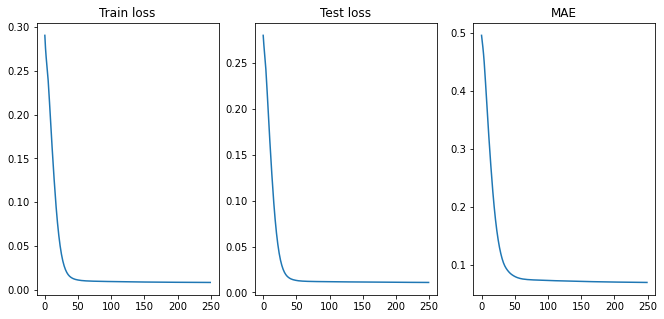

In [49]:
# Loss vs Epoch
plot_history(history)

## Hyperparameter Tuning

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

model_regressor = KerasRegressor(simple_autoencoder().model, verbose=1, batch_size=10, epochs=10)

#define the grid search parameters
dim = [5, 10, 15, 20, 25]
loss = ['mae','mse','mean_squared_logarithmic_error']
optimizer = ['Adam', 'SGD', 'RMSprop']
score = ['acc', 'mae','mse']

param_grid = dict(optimizer=optimizer,score = score, loss = loss, dim = dim)

In [42]:
random_search = RandomizedSearchCV(estimator=model_regressor, param_distributions=param_grid, n_iter=100)
random_search.fit(training_set_scaled, training_set_scaled)

Model: "model_510"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_511 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_1017 (Dense)           (None, 25)                16125     
_________________________________________________________________
dense_1018 (Dense)           (None, 644)               16744     
Total params: 32,869
Trainable params: 32,869
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.5095 - mae: 0.5095
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.5015 - mae: 0.5015
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4927 - mae: 0.4927
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.4846 - mae: 0.4846
Epoch 5/10


32/32 [==============================] - 0s 2ms/step - loss: 0.4717 - mae: 0.4717
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4700 - mae: 0.4700
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4663 - mae: 0.4663
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.4568 - mae: 0.4568
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.4532 - mae: 0.4532
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4424 - mae: 0.4424
Model: "model_515"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_516 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_1027 (Dense)           (None, 5)                 3225      
_________________________________________________________________
dense_1028 (Dense)           (None, 644

32/32 [==============================] - 1s 3ms/step - loss: 0.2325 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0960 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0377 - acc: 4.9265e-04
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0163 - acc: 0.0348
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0106 - acc: 0.1931
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0092 - acc: 0.1892
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0090 - acc: 0.2039
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0090 - acc: 0.2097
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0088 - acc: 0.1966
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0123 - acc: 0.1500
Model: "model_520"
___________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1344 - mae: 0.4980
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1334 - mae: 0.4985
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1297 - mae: 0.4923
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1294 - mae: 0.4949
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1281 - mae: 0.4945
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1237 - mae: 0.4863
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1230 - mae: 0.4875
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1217 - mae: 0.4864
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1203 - mae: 0.4852
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1182 - mae: 0.4822
Model: "model_525"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1025 - acc: 0.0092
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0675 - acc: 0.1487
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0652 - acc: 0.2056
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0647 - acc: 0.1521
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0643 - acc: 0.1876
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0630 - acc: 0.1836
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0607 - acc: 0.1719
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0592 - acc: 0.1590
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0558 - acc: 0.0392
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0509 - acc: 0.0000e+00
Model: "model_530"
________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.4999 - mse: 0.2879
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4980 - mse: 0.2863
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.5012 - mse: 0.2892
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4916 - mse: 0.2799
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4844 - mse: 0.2740
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4856 - mse: 0.2756
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4813 - mse: 0.2723
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4741 - mse: 0.2662
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4721 - mse: 0.2654
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4682 - mse: 0.2659
Model: "model_535"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.3001 - mae: 0.5106
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2897 - mae: 0.5041
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2814 - mae: 0.4979
Epoch 4/10
32/32 [==============================] - 0s 6ms/step - loss: 0.2751 - mae: 0.4941
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2722 - mae: 0.4917
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2664 - mae: 0.4856
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2685 - mae: 0.4885
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2652 - mae: 0.4850
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2627 - mae: 0.4818
Epoch 10/10
8/8 [==============================] - 1s 3ms/step - loss: 0.2617 - mae: 0.4785
Model: "model_540"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1512 - mse: 0.2818
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1482 - mse: 0.2807
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1481 - mse: 0.2842
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1465 - mse: 0.2839
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1449 - mse: 0.2828
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1426 - mse: 0.2797
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1419 - mse: 0.2804
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1416 - mse: 0.2816
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1406 - mse: 0.2808
Epoch 10/10
8/8 [==============================] - 2s 2ms/step - loss: 0.1408 - mse: 0.2849
Model: "model_545"
____________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2026 - acc: 0.0018
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0260 - acc: 0.0338
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0105 - acc: 0.1810
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0098 - acc: 0.1791
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0099 - acc: 0.1779
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0096 - acc: 0.2175
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0089 - acc: 0.2145
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0085 - acc: 0.1596
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0088 - acc: 0.2354
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0110 - acc: 0.1500
Model: "model_550"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2770 - acc: 0.0045 
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0719 - acc: 0.1905
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0678 - acc: 0.1662
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0684 - acc: 0.1657
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0682 - acc: 0.1593
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0681 - acc: 0.1628
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0662 - acc: 0.1696
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0673 - acc: 0.1599
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0675 - acc: 0.1850
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0732 - acc: 0.1500
Model: "model_555"
______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1105 - mae: 0.4487
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0708 - mae: 0.3257
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0690 - mae: 0.3134
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0695 - mae: 0.3137
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0692 - mae: 0.3126
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0664 - mae: 0.3055
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0640 - mae: 0.2964
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0623 - mae: 0.2908
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0593 - mae: 0.2819
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0575 - mae: 0.2751
Model: "model_560"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2211 - mae: 0.4158
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0224 - mae: 0.1055
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0104 - mae: 0.0707
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0095 - mae: 0.0671
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0094 - mae: 0.0671
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0094 - mae: 0.0669
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0089 - mae: 0.0652
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0089 - mae: 0.0648
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0089 - mae: 0.0653
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0111 - mae: 0.0705
Model: "model_565"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 2ms/step - loss: 0.4231 - mae: 0.4231
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1571 - mae: 0.1571
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0764 - mae: 0.0764
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0692 - mae: 0.0692
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0686 - mae: 0.0686
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0670 - mae: 0.0670
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0667 - mae: 0.0667
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0660 - mae: 0.0660
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0638 - mae: 0.0638
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0696 - mae: 0.0696
Model: "model_570"
____________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.4335 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1693 - acc: 0.0117
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0793 - acc: 0.0340
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0700 - acc: 0.1952
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0663 - acc: 0.1921
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0664 - acc: 0.1765
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0653 - acc: 0.1830
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0649 - acc: 0.1947
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0651 - acc: 0.2191
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0697 - acc: 0.1500
Model: "model_575"
___________________________________________________________

8/8 [==============================] - 0s 4ms/step - loss: 0.4345 - acc: 0.0000e+00
Model: "model_579"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_580 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_1155 (Dense)           (None, 20)                12900     
_________________________________________________________________
dense_1156 (Dense)           (None, 644)               13524     
Total params: 26,424
Trainable params: 26,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 1ms/step - loss: 0.5019 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4938 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4839 - acc: 0.0000e+00
Epoch 4/

32/32 [==============================] - 0s 1ms/step - loss: 0.2725 - mse: 0.2725
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2692 - mse: 0.2692
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2729 - mse: 0.2729
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2755 - mse: 0.2755
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2734 - mse: 0.2734
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2692 - mse: 0.2692
Epoch 10/10
8/8 [==============================] - 1s 2ms/step - loss: 0.2626 - mse: 0.2626
Model: "model_584"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_585 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_1165 (Dense)           (None, 5)                 3225      
____________

32/32 [==============================] - 1s 1ms/step - loss: 0.3328 - mse: 0.1664
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0858 - mse: 0.0150
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0703 - mse: 0.0103
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0703 - mse: 0.0102
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0682 - mse: 0.0099
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0703 - mse: 0.0103
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0689 - mse: 0.0102
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0703 - mse: 0.0103
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0707 - mse: 0.0105
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.0581 - mse: 0.0073
Model: "model_589"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2047 - mae: 0.3914
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0161 - mae: 0.0919
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0117 - mae: 0.0757
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0111 - mae: 0.0725
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0105 - mae: 0.0707
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0097 - mae: 0.0684
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0098 - mae: 0.0678
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0100 - mae: 0.0688
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0100 - mae: 0.0687
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0072 - mae: 0.0587
Model: "model_594"
_______________________________________________________________

32/32 [==============================] - 1s 1ms/step - loss: 0.2960 - mse: 0.2960
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2875 - mse: 0.2875
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2774 - mse: 0.2774
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2707 - mse: 0.2707
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2635 - mse: 0.2635
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2586 - mse: 0.2586
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2586 - mse: 0.2586
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2497 - mse: 0.2497
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2444 - mse: 0.2444
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.2348 - mse: 0.2348
Model: "model_599"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.3983 - mse: 0.2120
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1100 - mse: 0.0248
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0751 - mse: 0.0116
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0715 - mse: 0.0107
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0698 - mse: 0.0102
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0671 - mse: 0.0096
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0674 - mse: 0.0096
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0689 - mse: 0.0101
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0665 - mse: 0.0094
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0563 - mse: 0.0070
Model: "model_604"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.0890 - mae: 0.3942
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0658 - mae: 0.3140
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0571 - mae: 0.2853
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0527 - mae: 0.2689
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0484 - mae: 0.2528
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0456 - mae: 0.2453
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0437 - mae: 0.2355
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0417 - mae: 0.2291
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0382 - mae: 0.2149
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0334 - mae: 0.1923
Model: "model_609"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1072 - mse: 0.2910
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0694 - mse: 0.2347
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0689 - mse: 0.2335
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0697 - mse: 0.2357
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0684 - mse: 0.2316
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0663 - mse: 0.2261
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0650 - mse: 0.2236
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0598 - mse: 0.2091
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0557 - mse: 0.1983
Epoch 10/10
8/8 [==============================] - 1s 4ms/step - loss: 0.0493 - mse: 0.1793
Model: "model_614"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.3978 - mae: 0.3978
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1055 - mae: 0.1055
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0741 - mae: 0.0741
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0753 - mae: 0.0753
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0714 - mae: 0.0714
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0678 - mae: 0.0678
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0682 - mae: 0.0682
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0677 - mae: 0.0677
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0688 - mae: 0.0688
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0568 - mae: 0.0568
Model: "model_619"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1228 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0870 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0824 - acc: 0.0149
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0821 - acc: 0.0118
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0813 - acc: 0.0053
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0813 - acc: 0.0188
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0817 - acc: 0.0078
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0813 - acc: 0.0043
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0817 - acc: 0.0110
Epoch 10/10
8/8 [==============================] - 1s 2ms/step - loss: 0.0797 - acc: 0.0125
Model: "model_624"
_______________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.0907 - mse: 0.2522
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0692 - mse: 0.2218
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0614 - mse: 0.1990
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0524 - mse: 0.1772
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0464 - mse: 0.1609
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0398 - mse: 0.1438
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0372 - mse: 0.1369
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0365 - mse: 0.1347
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0361 - mse: 0.1342
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.0335 - mse: 0.1226
Model: "model_629"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.0984 - mse: 0.2600
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0722 - mse: 0.2196
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0675 - mse: 0.2009
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0579 - mse: 0.1763
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0506 - mse: 0.1598
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0463 - mse: 0.1491
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0429 - mse: 0.1428
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0413 - mse: 0.1363
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0388 - mse: 0.1323
Epoch 10/10
8/8 [==============================] - 1s 4ms/step - loss: 0.0361 - mse: 0.1214
Model: "model_634"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1400 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1367 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1342 - acc: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1330 - acc: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1317 - acc: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1285 - acc: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1257 - acc: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1241 - acc: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1233 - acc: 0.0000e+00
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1198 - acc: 0.0000e+00
Model: "model_639"
____________

32/32 [==============================] - 1s 2ms/step - loss: 0.3253 - acc: 0.0019 
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0834 - acc: 0.1512
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0705 - acc: 0.1992
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0695 - acc: 0.2185
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0694 - acc: 0.1384
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0700 - acc: 0.1606
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0690 - acc: 0.1633
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0704 - acc: 0.1476
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0713 - acc: 0.1987
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0575 - acc: 0.2125
Model: "model_644"
______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.3857 - mae: 0.3857
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1247 - mae: 0.1247
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0749 - mae: 0.0749
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0690 - mae: 0.0690
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0699 - mae: 0.0699
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0710 - mae: 0.0710
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0690 - mae: 0.0690
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0695 - mae: 0.0695
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0697 - mae: 0.0697
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0621 - mae: 0.0621
Model: "model_649"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1678 - acc: 0.0090
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0120 - acc: 0.1920
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0107 - acc: 0.1636
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0113 - acc: 0.1607
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0103 - acc: 0.1772
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0101 - acc: 0.1676
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0105 - acc: 0.1359
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0101 - acc: 0.1745
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0100 - acc: 0.1804
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.0085 - acc: 0.2125
Model: "model_654"
_______________________________________________________________

32/32 [==============================] - 1s 1ms/step - loss: 0.2864 - mse: 0.2864
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2825 - mse: 0.2825
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2826 - mse: 0.2826
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2782 - mse: 0.2782
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2780 - mse: 0.2780
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2708 - mse: 0.2708
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2750 - mse: 0.2750
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2668 - mse: 0.2668
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2617 - mse: 0.2617
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.2596 - mse: 0.2596
Model: "model_659"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1160 - mae: 0.4527
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0727 - mae: 0.3297
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0675 - mae: 0.3005
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0681 - mae: 0.2977
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0668 - mae: 0.2945
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0669 - mae: 0.2942
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0666 - mae: 0.2939
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0666 - mae: 0.2939
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0621 - mae: 0.2803
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0542 - mae: 0.2508
Model: "model_664"
____________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1165 - mse: 0.2586
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0726 - mse: 0.1927
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0675 - mse: 0.1822
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0656 - mse: 0.1775
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0652 - mse: 0.1767
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0659 - mse: 0.1783
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0660 - mse: 0.1787
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0644 - mse: 0.1757
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0631 - mse: 0.1714
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0546 - mse: 0.1482
Model: "model_669"
_______________________________________________________________

32/32 [==============================] - 1s 1ms/step - loss: 0.1467 - mae: 0.5007
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.1457 - mae: 0.5037
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.1431 - mae: 0.5025
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.1413 - mae: 0.5019
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1393 - mae: 0.5008
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.1369 - mae: 0.4974
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1380 - mae: 0.5023
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1348 - mae: 0.4966
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1335 - mae: 0.4953
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1313 - mae: 0.4941
Model: "model_674"
_______________________________________________________________

32/32 [==============================] - 1s 3ms/step - loss: 0.4404 - mse: 0.2385
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1717 - mse: 0.0530
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0792 - mse: 0.0129
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0730 - mse: 0.0111
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0734 - mse: 0.0114
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0701 - mse: 0.0104
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0686 - mse: 0.0102
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0673 - mse: 0.0095
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0675 - mse: 0.0097
Epoch 10/10
8/8 [==============================] - 1s 2ms/step - loss: 0.0575 - mse: 0.0071
Model: "model_679"
_______________________________________________________________

32/32 [==============================] - 1s 1ms/step - loss: 0.5046 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4950 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4867 - acc: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4797 - acc: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4707 - acc: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4650 - acc: 6.0087e-04
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4572 - acc: 0.0021
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4487 - acc: 0.0068
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4460 - acc: 0.0000e+00
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4299 - acc: 0.0000e+00
Model: "model_684"
_______________________________

Epoch 1/10
32/32 [==============================] - 2s 3ms/step - loss: 0.1394 - mae: 0.5021
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1355 - mae: 0.4962
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1368 - mae: 0.5018
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1326 - mae: 0.4953
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1321 - mae: 0.4963
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1306 - mae: 0.4940
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1300 - mae: 0.4948
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1262 - mae: 0.4874
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1261 - mae: 0.4887
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1227 - mae: 0.4844
Model: "model_689"
____________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2844 - acc: 2.8715e-04
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2792 - acc: 0.0068
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2786 - acc: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2716 - acc: 1.8939e-04
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2707 - acc: 0.0055
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2704 - acc: 0.0042
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2680 - acc: 0.0078
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2626 - acc: 0.0038
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2669 - acc: 0.0015
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.2595 - acc: 0.0000e+00
Model: "model_694"
_______________________________________________

Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2882 - mae: 0.5080
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2831 - mae: 0.5041
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2825 - mae: 0.5055
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2730 - mae: 0.4974
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2773 - mae: 0.5012
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2736 - mae: 0.4974
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2729 - mae: 0.4971
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2718 - mae: 0.4964
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2692 - mae: 0.4930
Epoch 10/10
8/8 [==============================] - 1s 3ms/step - loss: 0.2656 - mae: 0.4922
Model: "model_699"
____________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.4011 - acc: 1.8939e-04
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1064 - acc: 0.0215
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0756 - acc: 0.1762
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0740 - acc: 0.1731
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0726 - acc: 0.1666
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0695 - acc: 0.1603
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0680 - acc: 0.1654
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0672 - acc: 0.1724
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0681 - acc: 0.1509
Epoch 10/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0562 - acc: 0.2125
Model: "model_704"
___________________________________________________________

32/32 [==============================] - 1s 3ms/step - loss: 0.2029 - mse: 0.2029
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0159 - mse: 0.0159
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0122 - mse: 0.0122
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0110 - mse: 0.0110
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0114 - mse: 0.0114
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0101 - mse: 0.0101
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0095 - mse: 0.0095
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0100 - mse: 0.0100
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0097 - mse: 0.0097
Epoch 10/10
8/8 [==============================] - 1s 2ms/step - loss: 0.0070 - mse: 0.0070
Model: "model_709"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 5ms/step - loss: 0.3294 - mae: 0.3294
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0857 - mae: 0.0857
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0697 - mae: 0.0697
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0728 - mae: 0.0728
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0682 - mae: 0.0682
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0688 - mae: 0.0688
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0708 - mae: 0.0708
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0694 - mae: 0.0694
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0700 - mae: 0.0700
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.0616 - mae: 0.0616
Model: "model_714"
____________________________________________________

32/32 [==============================] - 1s 1ms/step - loss: 0.4983 - mse: 0.2804
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4937 - mse: 0.2755
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4898 - mse: 0.2735
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4844 - mse: 0.2698
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4800 - mse: 0.2666
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4777 - mse: 0.2653
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4755 - mse: 0.2647
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4715 - mse: 0.2612
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4604 - mse: 0.2519
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4572 - mse: 0.2480
Model: "model_719"
_______________________________________________________________

32/32 [==============================] - 1s 1ms/step - loss: 0.2855 - acc: 0.0068 
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2777 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2746 - acc: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2706 - acc: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2659 - acc: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2652 - acc: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2619 - acc: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2573 - acc: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2593 - acc: 0.0000e+00
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.2520 - acc: 0.0000e+00
Model: "model_724"
__________________________

32/32 [==============================] - 1s 1ms/step - loss: 0.1792 - mae: 0.3547
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0156 - mae: 0.0878
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0107 - mae: 0.0720
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0101 - mae: 0.0708
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0107 - mae: 0.0719
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0114 - mae: 0.0742
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0104 - mae: 0.0707
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0107 - mae: 0.0726
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0103 - mae: 0.0710
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0080 - mae: 0.0631
Model: "model_729"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1327 - mse: 0.2914
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1314 - mse: 0.2937
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1275 - mse: 0.2886
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1261 - mse: 0.2897
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1243 - mse: 0.2895
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1229 - mse: 0.2899
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1212 - mse: 0.2891
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1192 - mse: 0.2877
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1167 - mse: 0.2844
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1140 - mse: 0.2817
Model: "model_734"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1262 - mae: 0.4671
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0915 - mae: 0.3800
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0824 - mae: 0.3343
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0789 - mae: 0.3127
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0766 - mae: 0.3026
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0720 - mae: 0.2915
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0678 - mae: 0.2807
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0613 - mae: 0.2680
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0560 - mae: 0.2510
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0491 - mae: 0.2226
Model: "model_739"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.0906 - mse: 0.2780
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0699 - mse: 0.2509
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0651 - mse: 0.2318
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0599 - mse: 0.2177
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0557 - mse: 0.2087
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0526 - mse: 0.2023
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0520 - mse: 0.1999
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0507 - mse: 0.1967
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0505 - mse: 0.1953
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0481 - mse: 0.1883
Model: "model_744"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.0982 - mae: 0.4264
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0628 - mae: 0.3123
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0617 - mae: 0.3058
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0618 - mae: 0.3036
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0558 - mae: 0.2881
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0541 - mae: 0.2806
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0521 - mae: 0.2740
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0496 - mae: 0.2649
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0452 - mae: 0.2473
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0420 - mae: 0.2294
Model: "model_749"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.3255 - mae: 0.3255
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0770 - mae: 0.0770
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0729 - mae: 0.0729
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0708 - mae: 0.0708
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0709 - mae: 0.0709
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0700 - mae: 0.0700
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0727 - mae: 0.0727
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0707 - mae: 0.0707
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0709 - mae: 0.0709
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.0666 - mae: 0.0666
Model: "model_754"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.3831 - acc: 7.1311e-04
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0926 - acc: 0.1221
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0715 - acc: 0.1422
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0699 - acc: 0.1648
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0704 - acc: 0.1980
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0688 - acc: 0.1808
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0666 - acc: 0.1501
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0678 - acc: 0.2135
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0665 - acc: 0.1559
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0556 - acc: 0.2125
Model: "model_759"
___________________________________________________________

32/32 [==============================] - 1s 1ms/step - loss: 0.3036 - mse: 0.1504
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0765 - mse: 0.0125
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0709 - mse: 0.0102
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0697 - mse: 0.0101
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0689 - mse: 0.0099
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0690 - mse: 0.0100
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0720 - mse: 0.0108
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0703 - mse: 0.0101
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0709 - mse: 0.0107
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.0585 - mse: 0.0073
Model: "model_764"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1406 - acc: 4.9265e-04
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1378 - acc: 2.8715e-04
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1345 - acc: 0.0030
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1320 - acc: 0.0035
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 0.1298 - acc: 0.0030
Epoch 6/10
32/32 [==============================] - ETA: 0s - loss: 0.1291 - acc: 0.0000e+0 - 0s 3ms/step - loss: 0.1291 - acc: 8.2966e-04
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1289 - acc: 0.0050
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1247 - acc: 0.0045
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 0.1260 - acc: 0.0016
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1218 - acc: 0.0000e+00
Model: "model_769"
_____

32/32 [==============================] - 1s 2ms/step - loss: 0.5009 - mse: 0.2818
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4985 - mse: 0.2793
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.5000 - mse: 0.2803
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.4975 - mse: 0.2785
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4947 - mse: 0.2771
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4951 - mse: 0.2770
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4913 - mse: 0.2736
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4883 - mse: 0.2710
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4890 - mse: 0.2722
Epoch 10/10
8/8 [==============================] - 1s 1ms/step - loss: 0.4833 - mse: 0.2647
Model: "model_774"
_______________________________________________________________

32/32 [==============================] - 1s 3ms/step - loss: 0.1487 - acc: 0.0113
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1475 - acc: 0.0089
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1436 - acc: 0.0016
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1414 - acc: 2.8715e-04
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1397 - acc: 0.0023
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1384 - acc: 0.0055
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1363 - acc: 0.0020
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1361 - acc: 0.0050
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1337 - acc: 0.0068
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1324 - acc: 0.0000e+00
Model: "model_779"
_______________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2286 - mae: 0.4278
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0340 - mae: 0.1340
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0115 - mae: 0.0755
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0108 - mae: 0.0718A: 0s - loss: 0.0107 - mae: 0.071
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0105 - mae: 0.0707
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0103 - mae: 0.0704
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0102 - mae: 0.0698
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0099 - mae: 0.0681
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0099 - mae: 0.0683
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0070 - mae: 0.0568
Model: "model_784"
______________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.0990 - mae: 0.4196
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0720 - mae: 0.3248
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0706 - mae: 0.3142
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0581 - mae: 0.2809
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0557 - mae: 0.2678
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0520 - mae: 0.2553
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0470 - mae: 0.2378
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0437 - mae: 0.2248
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0403 - mae: 0.2146
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0373 - mae: 0.2027
Model: "model_789"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 4ms/step - loss: 0.1029 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0678 - acc: 0.0016
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0662 - acc: 0.1277
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0668 - acc: 0.1790
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0666 - acc: 0.1581
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0671 - acc: 0.1680
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0652 - acc: 0.1752
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0642 - acc: 0.1760
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0588 - acc: 0.1268
Epoch 10/10
8/8 [==============================] - 1s 4ms/step - loss: 0.0512 - acc: 0.1375
Model: "model_794"
________________________________________________

input_799 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_1593 (Dense)           (None, 5)                 3225      
_________________________________________________________________
dense_1594 (Dense)           (None, 644)               3864      
Total params: 7,089
Trainable params: 7,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 2s 4ms/step - loss: 0.1314 - mse: 0.2669
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0904 - mse: 0.2072
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0792 - mse: 0.1859
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0771 - mse: 0.1815
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0755 - mse: 0.1776
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss:

Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0431 - acc: 0.0049
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0403 - acc: 9.0250e-04
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0383 - acc: 0.1335
Epoch 10/10
8/8 [==============================] - 1s 4ms/step - loss: 0.0343 - acc: 0.2750
Model: "model_803"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_804 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_1603 (Dense)           (None, 10)                6450      
_________________________________________________________________
dense_1604 (Dense)           (None, 644)               7084      
Total params: 13,534
Trainable params: 13,534
Non-trainable params: 0
_________________________________________________________________
Epoch 1/

Epoch 1/10
32/32 [==============================] - 2s 3ms/step - loss: 0.4533 - mae: 0.4533
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2751 - mae: 0.2751
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1412 - mae: 0.1412
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0871 - mae: 0.0871
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0737 - mae: 0.0737
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0710 - mae: 0.0710
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0684 - mae: 0.0684
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0674 - mae: 0.0674
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0665 - mae: 0.0665
Epoch 10/10
8/8 [==============================] - 1s 3ms/step - loss: 0.0597 - mae: 0.0597
Model: "model_808"
____________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 3ms/step - loss: 0.0905 - mae: 0.3994
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0692 - mae: 0.3212
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0623 - mae: 0.2951
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0553 - mae: 0.2708
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0527 - mae: 0.2606
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0482 - mae: 0.2466
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0465 - mae: 0.2410
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0451 - mae: 0.2363
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0447 - mae: 0.2323
Epoch 10/10
8/8 [==============================] - 1s 4ms/step - loss: 0.0420 - mae: 0.2213
Model: "model_813"
____________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2883 - mse: 0.2883
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2824 - mse: 0.2824
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2805 - mse: 0.2805
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2746 - mse: 0.2746
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2712 - mse: 0.2712
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2690 - mse: 0.2690
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2649 - mse: 0.2649
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2674 - mse: 0.2674
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2600 - mse: 0.2600
Epoch 10/10
8/8 [==============================] - 1s 2ms/step - loss: 0.2555 - mse: 0.2555
Model: "model_818"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 4ms/step - loss: 0.1660 - mae: 0.3331
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0120 - mae: 0.0761
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0115 - mae: 0.0751
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0104 - mae: 0.0712
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0107 - mae: 0.0716
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0102 - mae: 0.0705
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0100 - mae: 0.0700
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0103 - mae: 0.0705
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0107 - mae: 0.0717
Epoch 10/10
8/8 [==============================] - 1s 2ms/step - loss: 0.0078 - mae: 0.0625
Model: "model_823"
____________________________________________________

Epoch 1/10
32/32 [==============================] - 3s 3ms/step - loss: 0.2035 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0168 - acc: 0.0204
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0111 - acc: 0.1412
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0107 - acc: 0.1435
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0104 - acc: 0.1619
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0099 - acc: 0.1510
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0095 - acc: 0.1382
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0099 - acc: 0.1429
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0096 - acc: 0.1389
Epoch 10/10
8/8 [==============================] - 1s 3ms/step - loss: 0.0074 - acc: 0.2500
Model: "model_828"
________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 3ms/step - loss: 0.2044 - mae: 0.4010
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0390 - mae: 0.1490
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0126 - mae: 0.0793
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0102 - mae: 0.0699
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0101 - mae: 0.0690
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0103 - mae: 0.0697
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0101 - mae: 0.0684
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0103 - mae: 0.0699
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0104 - mae: 0.0701
Epoch 10/10
8/8 [==============================] - 1s 3ms/step - loss: 0.0075 - mae: 0.0601
Model: "model_833"
____________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 4ms/step - loss: 0.0983 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0743 - acc: 0.0084
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0666 - acc: 0.0199
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0545 - acc: 0.1913
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0514 - acc: 0.1660
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0446 - acc: 0.1391
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0364 - acc: 0.1614
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0341 - acc: 0.1429
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0329 - acc: 0.1329
Epoch 10/10
8/8 [==============================] - 1s 3ms/step - loss: 0.0293 - acc: 0.2750
Model: "model_838"
________________________________________________

32/32 [==============================] - 2s 2ms/step - loss: 0.3767 - mse: 0.1902
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1224 - mse: 0.0303
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0751 - mse: 0.0118
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0701 - mse: 0.0105
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0688 - mse: 0.0099
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0683 - mse: 0.0099
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0664 - mse: 0.0094
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0712 - mse: 0.0107
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0685 - mse: 0.0099
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0611 - mse: 0.0077
Model: "model_843"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2950 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2921 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2838 - acc: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2754 - acc: 0.0030
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2728 - acc: 0.0020
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2693 - acc: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2603 - acc: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2579 - acc: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2541 - acc: 0.0000e+00
Epoch 10/10
8/8 [==============================] - 1s 3ms/step - loss: 0.2419 - acc: 0.0000e+00
Model: "model_848"
____________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1066 - mse: 0.2520
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0750 - mse: 0.2008
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0727 - mse: 0.1938
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0587 - mse: 0.1659
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0525 - mse: 0.1525
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0482 - mse: 0.1427
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0430 - mse: 0.1297
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0420 - mse: 0.1270
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0399 - mse: 0.1216
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0370 - mse: 0.1152
Model: "model_853"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 3ms/step - loss: 0.0931 - acc: 0.0016
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0682 - acc: 0.1016
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0648 - acc: 0.1934
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0609 - acc: 0.1373
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0545 - acc: 0.1224
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0499 - acc: 0.1943
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0464 - acc: 0.1371
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0434 - acc: 0.1440
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0424 - acc: 0.1562
Epoch 10/10
8/8 [==============================] - 1s 3ms/step - loss: 0.0397 - acc: 0.2625
Model: "model_858"
____________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 2ms/step - loss: 0.2195 - mse: 0.2195
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0326 - mse: 0.0326
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0112 - mse: 0.0112
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0115 - mse: 0.0115
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0112 - mse: 0.0112
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0100 - mse: 0.0100
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0108 - mse: 0.0108
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0098 - mse: 0.0098
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0099 - mse: 0.0099
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0074 - mse: 0.0074
Model: "model_863"
____________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2027 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0187 - acc: 0.0411
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0111 - acc: 0.1264
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0109 - acc: 0.1673
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0110 - acc: 0.1330
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0100 - acc: 0.1517
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0095 - acc: 0.1635
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0097 - acc: 0.1568
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0099 - acc: 0.1395
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0074 - acc: 0.2750
Model: "model_868"
___________________________________________________________

32/32 [==============================] - 1s 1ms/step - loss: 0.4969 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4961 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4985 - acc: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4969 - acc: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4908 - acc: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4917 - acc: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4890 - acc: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4920 - acc: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4873 - acc: 0.0028
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4820 - acc: 0.0000e+00
Model: "model_873"
___________________________

Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.5006 - mae: 0.5006
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4996 - mae: 0.4996
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4980 - mae: 0.4980
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.4898 - mae: 0.4898
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.4904 - mae: 0.4904
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4864 - mae: 0.4864
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4813 - mae: 0.4813
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.4807 - mae: 0.4807
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4719 - mae: 0.4719
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4669 - mae: 0.4669
Model: "model_878"
____________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.3743 - acc: 0.0113
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0866 - acc: 0.1202
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0715 - acc: 0.1933
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0695 - acc: 0.1724
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0665 - acc: 0.1319
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0678 - acc: 0.1390
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0670 - acc: 0.2042
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0666 - acc: 0.1421
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0654 - acc: 0.1718
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0590 - acc: 0.2750
Model: "model_883"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 1s 1ms/step - loss: 0.5054 - mae: 0.5054
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.5075 - mae: 0.5075
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4996 - mae: 0.4996
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.5017 - mae: 0.5017
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4985 - mae: 0.4985
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4942 - mae: 0.4942
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4980 - mae: 0.4980
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4919 - mae: 0.4919
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4941 - mae: 0.4941
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4915 - mae: 0.4915
Model: "model_888"
____________________________________________________

32/32 [==============================] - 2s 2ms/step - loss: 0.1275 - mse: 0.2706
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0937 - mse: 0.2195
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0856 - mse: 0.2028
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0836 - mse: 0.1974
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0798 - mse: 0.1851
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0717 - mse: 0.1666
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0588 - mse: 0.1413
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0530 - mse: 0.1286
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0495 - mse: 0.1205
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - mse: 0.1026
Model: "model_893"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 2ms/step - loss: 0.2950 - mae: 0.5023
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2883 - mae: 0.4977
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2809 - mae: 0.4922
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2737 - mae: 0.4856
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2688 - mae: 0.4829
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2631 - mae: 0.4769
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2597 - mae: 0.4736
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2555 - mae: 0.4691
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2529 - mae: 0.4663
Epoch 10/10
8/8 [==============================] - 1s 2ms/step - loss: 0.2428 - mae: 0.4580
Model: "model_898"
____________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 3ms/step - loss: 0.1943 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0372 - acc: 0.0030
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0132 - acc: 0.0091
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0102 - acc: 0.0723
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0102 - acc: 0.1458
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0098 - acc: 0.1733
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0099 - acc: 0.1706
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0103 - acc: 0.1774
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0101 - acc: 0.1448
Epoch 10/10
8/8 [==============================] - 1s 3ms/step - loss: 0.0074 - acc: 0.2750
Model: "model_903"
________________________________________________

Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.3750 - mse: 0.1942
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0881 - mse: 0.0155
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0730 - mse: 0.0112
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0702 - mse: 0.0104
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0688 - mse: 0.0103
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0670 - mse: 0.0097
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0677 - mse: 0.0098
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0674 - mse: 0.0097
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0664 - mse: 0.0096
Epoch 10/10
8/8 [==============================] - 1s 2ms/step - loss: 0.0592 - mse: 0.0073
Model: "model_908"
____________________________________________________

Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2381 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0677 - acc: 1.8939e-04
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0191 - acc: 0.0179
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0128 - acc: 0.1654
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0114 - acc: 0.1630
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0107 - acc: 0.1654
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0114 - acc: 0.1677
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0101 - acc: 0.1524
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0099 - acc: 0.1559
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0075 - acc: 0.2750
Model: "model_913"
____________________________________________

Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1538 - mae: 0.5013
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1531 - mae: 0.5042
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1497 - mae: 0.4998
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1471 - mae: 0.4976
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1488 - mae: 0.5035
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1474 - mae: 0.5035
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1432 - mae: 0.4968
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1420 - mae: 0.4957
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1433 - mae: 0.5001
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1391 - mae: 0.4949
Model: "model_918"
____________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 4ms/step - loss: 0.1858 - acc: 0.0017
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0148 - acc: 0.1581
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0106 - acc: 0.1544
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0102 - acc: 0.1837
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0101 - acc: 0.1516
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0105 - acc: 0.1575
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0100 - acc: 0.1648
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0103 - acc: 0.1655
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0100 - acc: 0.1434
Epoch 10/10
8/8 [==============================] - 1s 2ms/step - loss: 0.0079 - acc: 0.2750
Model: "model_923"
____________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 3ms/step - loss: 0.1402 - mse: 0.2910
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1396 - mse: 0.2936
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1375 - mse: 0.2934
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1346 - mse: 0.2898
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1321 - mse: 0.2874
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1310 - mse: 0.2879
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1316 - mse: 0.2919
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1273 - mse: 0.2841
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1280 - mse: 0.2882
Epoch 10/10
8/8 [==============================] - 1s 4ms/step - loss: 0.1247 - mse: 0.2838
Model: "model_928"
____________________________________________________

32/32 [==============================] - 3s 4ms/step - loss: 0.2843 - mae: 0.2843
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0736 - mae: 0.0736
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0705 - mae: 0.0705
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0712 - mae: 0.0712
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0696 - mae: 0.0696
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0705 - mae: 0.0705
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0718 - mae: 0.0718
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0698 - mae: 0.0698
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0701 - mae: 0.0701
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0617 - mae: 0.0617
Model: "model_933"
_______________________________________________________________

32/32 [==============================] - 1s 3ms/step - loss: 0.3111 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0742 - acc: 0.0459
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0704 - acc: 0.1298
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0696 - acc: 0.1367
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0713 - acc: 0.1248
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0692 - acc: 0.1298
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0686 - acc: 0.1589
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0700 - acc: 0.1437
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0696 - acc: 0.1831
Epoch 10/10
8/8 [==============================] - 1s 4ms/step - loss: 0.0612 - acc: 0.2750
Model: "model_938"
___________________________________________________________

32/32 [==============================] - 2s 2ms/step - loss: 0.2527 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1147 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0496 - acc: 7.5758e-04
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0243 - acc: 0.1647
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0157 - acc: 0.1674
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0122 - acc: 0.1664
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0123 - acc: 0.1612
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0118 - acc: 0.1456
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0105 - acc: 0.1326
Epoch 10/10
8/8 [==============================] - 1s 3ms/step - loss: 0.0079 - acc: 0.2625
Model: "model_943"
___________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 3ms/step - loss: 0.2508 - mse: 0.2508
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1132 - mse: 0.1132
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0483 - mse: 0.0483
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0241 - mse: 0.0241
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0152 - mse: 0.0152
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0123 - mse: 0.0123
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0118 - mse: 0.0118
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0113 - mse: 0.0113
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0106 - mse: 0.0106
Epoch 10/10
8/8 [==============================] - 1s 3ms/step - loss: 0.0077 - mse: 0.0077
Model: "model_948"
____________________________________________________

Epoch 1/10
32/32 [==============================] - 3s 3ms/step - loss: 0.3612 - mse: 0.1944
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0854 - mse: 0.0147
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0723 - mse: 0.0109
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0696 - mse: 0.0105
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0683 - mse: 0.0100
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0676 - mse: 0.0100
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0669 - mse: 0.0097
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0666 - mse: 0.0094
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0672 - mse: 0.0097
Epoch 10/10
8/8 [==============================] - 1s 4ms/step - loss: 0.0598 - mse: 0.0074
Model: "model_953"
____________________________________________________

32/32 [==============================] - 2s 3ms/step - loss: 0.1236 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0908 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0819 - acc: 0.0099
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0799 - acc: 0.0113
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0757 - acc: 0.0031
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0587 - acc: 6.7530e-04
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0489 - acc: 0.0129
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0441 - acc: 0.1369
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0385 - acc: 0.1330
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0315 - acc: 0.2750
Model: "model_958"
___________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1011 - mae: 0.4324
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0674 - mae: 0.3222
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0651 - mae: 0.3109
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0640 - mae: 0.3072
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0631 - mae: 0.3039
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0625 - mae: 0.3007
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0603 - mae: 0.2946
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0593 - mae: 0.2903
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0569 - mae: 0.2817
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0512 - mae: 0.2574
Model: "model_963"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2076 - mse: 0.2076
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0199 - mse: 0.0199
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0114 - mse: 0.0114
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0103 - mse: 0.0103
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0100 - mse: 0.0100
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0101 - mse: 0.0101
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0099 - mse: 0.0099
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0095 - mse: 0.0095
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0092 - mse: 0.0092
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0075 - mse: 0.0075
Model: "model_968"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1895 - acc: 0.0083
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0229 - acc: 0.1381
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0113 - acc: 0.1534
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0097 - acc: 0.1966
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0108 - acc: 0.1202
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0103 - acc: 0.1603
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0102 - acc: 0.1335
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0099 - acc: 0.1403
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0097 - acc: 0.1598
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0075 - acc: 0.2750
Model: "model_973"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1399 - mse: 0.2890
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1353 - mse: 0.2859
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1337 - mse: 0.2884
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1312 - mse: 0.2884
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1312 - mse: 0.2938
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1285 - mse: 0.2920
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1278 - mse: 0.2943
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1256 - mse: 0.2928
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1242 - mse: 0.2927
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1204 - mse: 0.2878
Model: "model_978"
_______________________________________________________________

32/32 [==============================] - 1s 1ms/step - loss: 0.4705 - mse: 0.2551
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2850 - mse: 0.1133
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1493 - mse: 0.0391
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0846 - mse: 0.0144
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0729 - mse: 0.0112
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0720 - mse: 0.0112
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0689 - mse: 0.0102
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0682 - mse: 0.0101
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0664 - mse: 0.0095
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.0599 - mse: 0.0075
Model: "model_983"
_______________________________________________________________

32/32 [==============================] - 1s 1ms/step - loss: 0.2847 - acc: 0.0060 
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2793 - acc: 0.0039
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2717 - acc: 0.0060
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2629 - acc: 0.0124
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2578 - acc: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2597 - acc: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2529 - acc: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2482 - acc: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2448 - acc: 0.0000e+00
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.2358 - acc: 0.0375
Model: "model_988"
__________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.4153 - acc: 0.0032 
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2213 - acc: 0.0068
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.1205 - acc: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0814 - acc: 0.0078
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0689 - acc: 0.0121
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0682 - acc: 0.1367
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0679 - acc: 0.1626
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0674 - acc: 0.1531
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0673 - acc: 0.1710
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.0602 - acc: 0.2750
Model: "model_993"
__________________________________________________________

32/32 [==============================] - 1s 1ms/step - loss: 0.1505 - mse: 0.2887
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1507 - mse: 0.2953
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.1488 - mse: 0.2964
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1449 - mse: 0.2925A: 0s - loss: 0.1450 - mse: 0.292
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1438 - mse: 0.2943
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1416 - mse: 0.2931
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1398 - mse: 0.2925
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1388 - mse: 0.2931
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1365 - mse: 0.2906
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.1346 - mse: 0.2896
Model: "model_998"
______________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.4633 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2818 - acc: 0.0101
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1500 - acc: 0.1371
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0880 - acc: 0.1340
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0735 - acc: 0.1694
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0687 - acc: 0.1432
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0684 - acc: 0.1387
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0676 - acc: 0.1299
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0668 - acc: 0.1448
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0597 - acc: 0.2625
Model: "model_1003"
__________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1777 - mse: 0.1777
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0152 - mse: 0.0152
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0108 - mse: 0.0108
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0101 - mse: 0.0101
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0106 - mse: 0.0106
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0102 - mse: 0.0102
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0102 - mse: 0.0102
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0100 - mse: 0.0100
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0100 - mse: 0.0100
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0075 - mse: 0.0075
Model: "model_1008"
______________________________________________________________

RandomizedSearchCV(estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fbeab92c2b0>,
                   n_iter=100,
                   param_distributions={'dim': [5, 10, 15, 20, 25],
                                        'loss': ['mae', 'mse',
                                                 'mean_squared_logarithmic_error'],
                                        'optimizer': ['Adam', 'SGD', 'RMSprop'],
                                        'score': ['acc', 'mae', 'mse']})

In [43]:
random_best_parameters = random_search.best_params_
random_best_parameters

{'score': 'mae', 'optimizer': 'Adam', 'loss': 'mse', 'dim': 25}